In [1]:
import multiprocessing
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count())
from jax.config import config

config.update("jax_enable_x64", True)
config.update('jax_disable_jit', False)
config.update("jax_debug_nans", False)
import jax
from jax import jit

In [2]:
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as onp
import sympy as sp
# import seaborn as sns
from utils.density_manipulations import histogram_history, expectation_history, hellinger_distance_history
from symbolic.sympy_to_jax import sympy_matrix_to_jax
from other_filter.resampling import normalize_log_weights, essl

In [3]:
import symbolic.one_d
from sde import SDESolverTypes, sde_solver
from sde.wiener import multidimensional_wiener_process
from other_filter.particlefilter_continuous_correlated import ContinuousParticleFilterCorrelated
from functools import partial
from projection_filter.one_d_exponential_family_projection_filter_gaussian_bijection import plain_gauss_bijection
from projection_filter.one_d_exponential_family_projection_filter_correlated \
    import OneDimensionalCorrelatedProjectionFilter

In [4]:

# set some matplotlib variables
plt.rcParams.update({
            "text.usetex": True,
            "font.family": "sans-serif",
            "font.sans-serif": "Helvetica",
            "font.size": 16,
            'text.latex.preamble': r'\usepackage{amsfonts}'
        })
markevery = 50
markersize= 5


In [5]:
def get_sp500_prices(start_date, end_date):
    try:
        # Download S&P 500 data from Yahoo Finance
        sp500_data = yf.download('^GSPC', start=start_date, end=end_date)

        # Extract the 'Adj Close' prices
        sp500_prices = sp500_data['Adj Close']

        return sp500_prices

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def vix_values(start_date, end_date):
    # Define the ticker symbol for VIX
    vix = yf.Ticker("^VIX")

    # Fetch historical data for the given dates
    hist = vix.history(start=start_date, end=end_date)

    # Return the 'Close' values (or adjust as needed)
    return hist['Close']

In [6]:
# Declare some constants:
kappa= 8.31 # 2.0
gamma= 0.13 # 5e-1 # default 1e-2
sigma_x= 0.66 # 4e-1
mu= 1.51e-2 #1.51e-2 #4e-2 # 0.3


# S0= 1e2 #initial asset price
# dt= 5.0e-3 #default 2e-3
# nt= 1000
rho = -8.00e-1 # The rho should be negative, the default value is -0.8
rho_conj = jnp.sqrt(1-rho**2)
# init_mean_scale = 1.e0
# var_scale = jnp.array([S0, jnp.log])

# use S & P index prices
start_date = "2000-12-01" # format YYYY-MM-DD
end_date = "2004-11-27" # format YYYY-MM-DD
sp500_prices = get_sp500_prices(start_date, end_date)
vix_history = vix_values(start_date, end_date).to_numpy()/100 # Scaled
v0 = vix_history[0] #initial volatility
price_record = jnp.array(sp500_prices.to_numpy())
skip = 1
price_record = price_record[::skip]
vix_history = vix_history[::skip]
nt = price_record.shape[0]
dt = skip/250 # working days in US is around 252 to 253, so since the data is collected every working days and the constants are given in year perspective, hence dt = 1 day/ working days in a years
S0 = price_record[0]
prngkey = onp.random.randint(0,100)
prng_key, subkey = jrandom.split(jrandom.PRNGKey(prngkey))
dV = multidimensional_wiener_process((nt, 1), dt, subkey)
measurement_record = jnp.log(price_record/S0)
init_mean_scale = 1.e0
var_scale = 1.0 # jnp.array([1e0, 1e1])

[*********************100%%**********************]  1 of 1 completed


In [7]:
measurement_record.shape

(1000,)

In [8]:
# For continuous particle filter
# For continuous particle filter
@partial(jnp.vectorize, signature='(n)->(n)')
def f_(x_):
    return jnp.array([kappa * (gamma - x_[0])])


@partial(jnp.vectorize, signature='(n)->(n,m)')
def g_(x_):
    # return jnp.array([[rho * sigma_x * jnp.sqrt(jnp.abs(x_)), rho_conj * sigma_x * jnp.sqrt(jnp.abs(x_))]])
    return jnp.array([[sigma_x * jnp.sqrt(jnp.abs(x_[0]))]])


@partial(jnp.vectorize, signature='(n)->(m)')
def h_(x_):
    return jnp.array([mu * - x_[0] / 2])


@partial(jnp.vectorize, signature='(n)->(m,p)')
def ell_(x_):
    return jnp.array([[jnp.sqrt(jnp.abs(x_[0])), ]])

# @partial(jnp.vectorize, signature='(n)->(n)')
def F(x_,t_):
    return jnp.array([kappa * (gamma - x_[0]), mu * - x_[0] / 2])

# @partial(jnp.vectorize, signature='(n)->(n,m)')
def G(x_,t_):
    return jnp.array([[sigma_x * jnp.sqrt(jnp.abs(x_[0])), 0],
                      [0, jnp.sqrt(jnp.abs(x_[0]))]])

In [9]:
def generate_monomials_up_to_order(x_: tuple[sp.Symbol], order: int):
    monomials = []
    b_term = x_[0]#sp.sqrt(x_[0])
    for i in range(order + 1):     
        a_term = b_term ** i
        monomials.append(a_term)
    monomials.pop(0)  # remove constant
    return sp.Matrix(monomials)

In [10]:
x, dw, dv = sp.symbols(('x1:2', 'dw1:2', 'dv1:2'), real=True)
t = sp.symbols('t')
v = x[0]
f = sp.Matrix([kappa * (gamma - v)])
g = sp.Matrix([[sigma_x * sp.sqrt(v)]])
dynamic_sde = symbolic.one_d.SDE(f, g, t, x, dw)
measurement_sde = symbolic.one_d.SDE(drifts=sp.Matrix([mu - v / 2]),
                                     diffusions=sp.Matrix([[sp.sqrt(v), ]]),
                                     time=t,
                                     variables=x,
                                     brownians=dv)
max_order = 2
n_dim = 1
natural_statistics_symbolic = generate_monomials_up_to_order(x, max_order)
tspan = jnp.arange(nt) * dt
# s_mat = jnp.array([[1.], [0.]])  # Default
s_mat = jnp.array([[rho]])  # Default
init_mean = init_mean_scale * jnp.array([v0, ])
var_core = jnp.diag(jnp.array([1.e-3, ])) #Default 1e-3
var_init = var_scale * var_core  #
var_init_inv = jnp.linalg.solve(var_init, jnp.eye(1))

# Use a generated data
dt=1/250
# prng_key, subkey = jrandom.split(jrandom.PRNGKey(prngkey))
# dW = multidimensional_wiener_process((nt, 2), dt, subkey)
# X0 = onp.array([init_mean[0], init_mean[0]])
# X_integrated = sde_solver(F, G, X0, tspan, dW, solver_type=SDESolverTypes.ItoEulerMaruyama)
# measurement_record = X_integrated[:, 1:]

natural_statistics, _ = sympy_matrix_to_jax(natural_statistics_symbolic, dynamic_sde.variables, disable_parameters=True)


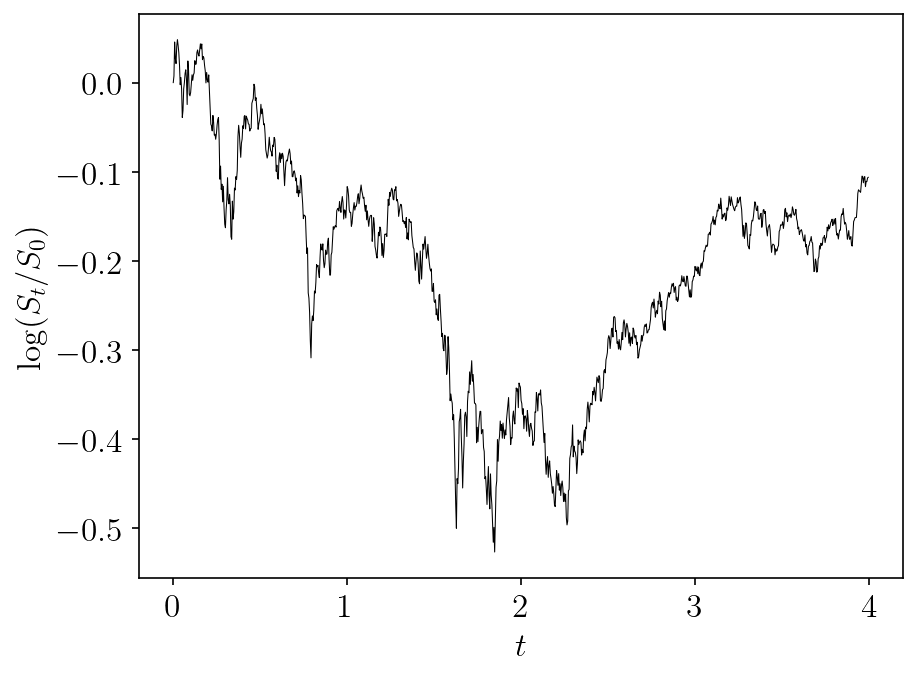

In [11]:
plt.figure(dpi=150)
plt.plot(tspan,measurement_record,'-k',linewidth=0.5,)
plt.ylabel('$\log(S_t/S_0)$')
plt.xlabel('$t$')
plt.grid(False)
# sns.despine()
plt.tight_layout()
plt.savefig('./heston/heston_measurement_record.pdf')

In [12]:
theta_1 = var_init_inv @ init_mean
theta_2 = -0.5 * var_init_inv
gaussian_initial_condition = jnp.zeros(len(natural_statistics_symbolic))
theta_indices_for_mu = []

# the mean
for i in range(init_mean.shape[0]):
    for k in range(len(natural_statistics_symbolic)):
        if natural_statistics_symbolic[k] == x[i]:
            gaussian_initial_condition = gaussian_initial_condition.at[k].set(theta_1[i])
            theta_indices_for_mu.append(k)
            break

theta_indices_for_mu = jnp.array(theta_indices_for_mu)
theta_indices_for_Sigma = onp.zeros((init_mean.shape[0], init_mean.shape[0]))
# the variance
for i in range(init_mean.shape[0]):
    for j in range(i, init_mean.shape[0]):
        multiplier = 2
        if i == j:
            multiplier = 1
        for k in range(len(natural_statistics_symbolic)):
            if natural_statistics_symbolic[k] == x[i] * x[j]:
                gaussian_initial_condition = gaussian_initial_condition.at[k].set(multiplier * theta_2[i, j])
                theta_indices_for_Sigma[i, j] = k
                theta_indices_for_Sigma[j, i] = k
                break

theta_indices_for_Sigma = jnp.array(theta_indices_for_Sigma, dtype=jnp.int32)
theta_indices_for_bijection_params = (theta_indices_for_mu, theta_indices_for_Sigma)
gauss_init = True

# a = init_mean[0]
# b = var_core[0]
# nongaussian_initial_condition = jnp.array([4*a**3-4*b**2,-6*a**2+2*b**2,4*a,-1])
initial_condition = gaussian_initial_condition

bijection_parameter_scale_factor = 1.2 #Default 1.2
_mu = init_mean
_Sigma = var_init
intial_bijection_parameters_gaussian = (_mu, _Sigma[0], bijection_parameter_scale_factor)

In [13]:
statistics_str = [str(stat).replace('**', '^').replace('x1', 'x_1').replace('x2', 'x_2').replace('*', '') for stat in natural_statistics_symbolic]
gauss_bijection = jit(jnp.vectorize(plain_gauss_bijection, signature='(d)->(d)', excluded=(1,)))

In [14]:
em_pf = OneDimensionalCorrelatedProjectionFilter(dynamic_sde,
                                                 measurement_sde,
                                                 natural_statistics_symbolic,
                                                 constants=None,
                                                 initial_condition=initial_condition,
                                                 measurement_record=measurement_record,
                                                 delta_t=dt,
                                                 noise_correlation_matrix=s_mat,
                                                 bijection_parameters=intial_bijection_parameters_gaussian,
                                                 nodes_number=9,
                                                 bijection=gauss_bijection,
                                                 theta_indices_for_bijection_params=
                                                 theta_indices_for_bijection_params,
                                                 moment_matching_iterations=8
                                                 )

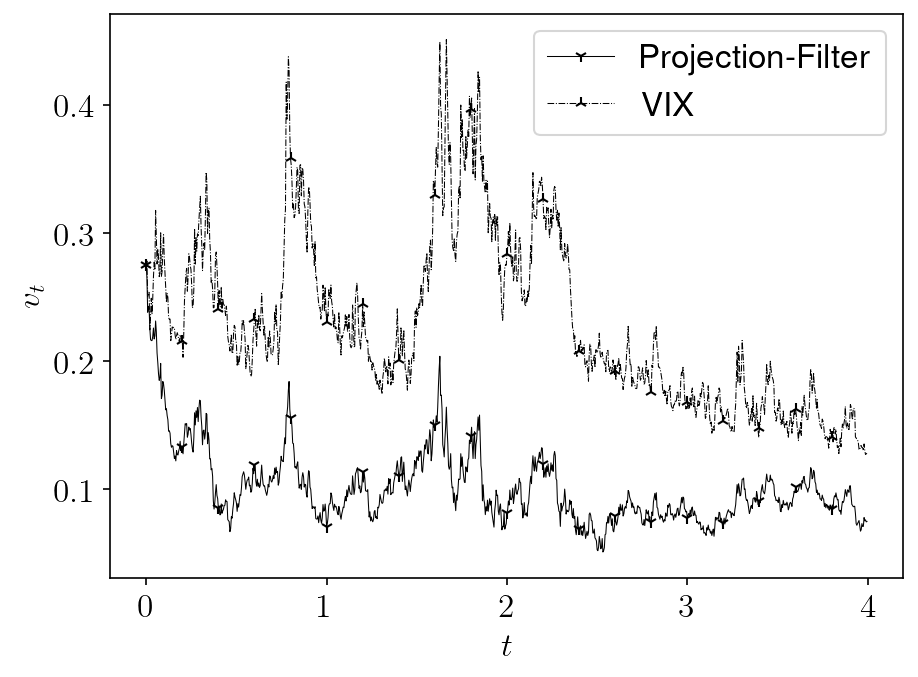

In [15]:
em_pf.propagate()
moments_projection_filter = em_pf.get_extended_statistics_expectation()
plt.figure(dpi=150)
plt.plot(tspan, moments_projection_filter[:, 0],'-k',linewidth=0.5,label='Projection-Filter',marker='1',markevery=markevery)
plt.plot(tspan, vix_history,'-.k',linewidth=0.5,label='VIX',marker='2',markevery=markevery)
plt.ylabel('$v_t$')
plt.xlabel('$t$')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig('./heston/heston_volatility_comparison_with_vix.pdf')

In [16]:
x_max = 0.5
x_lim = jnp.array([0,x_max])
nb_of_points = jnp.array([150],dtype=jnp.int32) #default 1000
x_grid, initial_density = em_pf.exponential_density.get_density_values(x_lim,initial_condition,nb_of_points=nb_of_points,bijection_params=intial_bijection_parameters_gaussian)
_, density_history_projection, bijected_abscissa_history = em_pf.get_density_values(x_lim,nb_of_points)

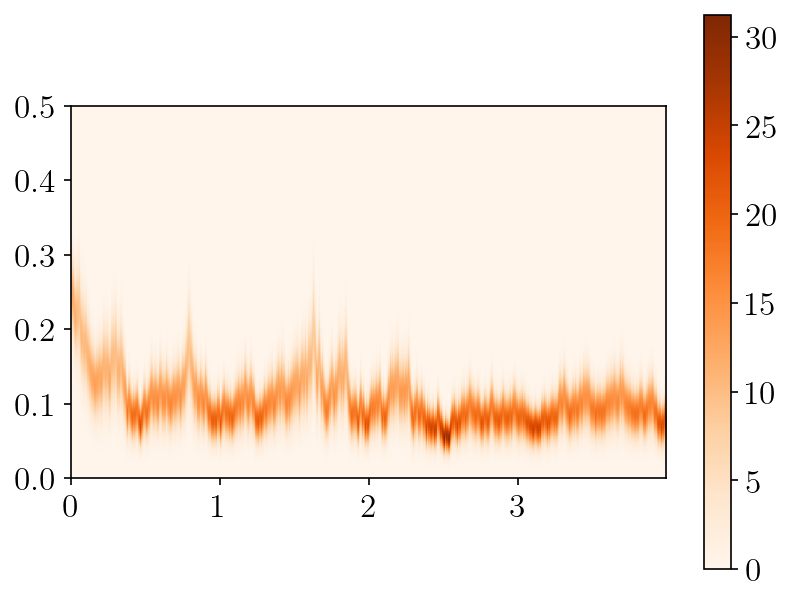

In [17]:
# x_max = 0.8
extent = jnp.array([[0,tspan[-1]],[0,x_max]])
plt.figure(dpi=150)
plt.imshow(density_history_projection.T, cmap=plt.cm.Oranges, extent=extent.flatten(),
                            origin='lower', alpha=1, aspect=5)
plt.colorbar()
# plt.plot(tspan,vix_history,linewidth=0.5)

In [18]:
n_devices = jax.local_device_count()
prng_key, subkey = jrandom.split(prng_key)
n_particle_per_device = 1000
cpf = ContinuousParticleFilterCorrelated(n_devices=n_devices,
                                         n_particle_per_device=n_particle_per_device,
                                         initial_samples=em_pf.exponential_density.sample(
                                           (n_devices, n_particle_per_device), initial_condition,
                                           theta_indices_for_mu,
                                           intial_bijection_parameters_gaussian,
                                           subkey),
                                         measurement_history=measurement_record,
                                         process_drift=f_,
                                         process_diffusion=g_,
                                         measurement_drift=h_,
                                         measurement_diffusion=ell_,
                                         process_brownian_dim=1,
                                         dt=dt,
                                         constraint=None,
                                         prng_key=prng_key,
                                         noise_correlation_matrix=s_mat,
                                         resampling="systematic"
                                         )
_, _, x_particle_history, neg_likelihood_history, log_weights_history, _ = cpf.run()
x_particle_history = onp.asarray(x_particle_history).reshape((nt, n_devices * n_particle_per_device, 1))
log_weights_history = log_weights_history.reshape((nt, n_devices * n_particle_per_device))
log_weights_history = jnp.vectorize(normalize_log_weights, signature='(n)->(n)')(log_weights_history)
essl_history = jnp.vectorize(essl, signature='(n)->()')(log_weights_history)

In [19]:
rel_ent_history = em_pf.empirical_kld(x_particle_history)
moments_particle_filter = expectation_history(jnp.vectorize(em_pf.natural_statistics,signature='(n)->(m)'),x_particle_history)
dx = (x_lim[1]-x_lim[0])/nb_of_points
xbins = jnp.linspace(x_lim[0] - dx, x_lim[1] + dx, nb_of_points[0] + 1).squeeze()
empirical_den_pf_history = histogram_history(x_particle_history, xbins)
hell_dist_hist = hellinger_distance_history(density_history_projection, empirical_den_pf_history, dx)

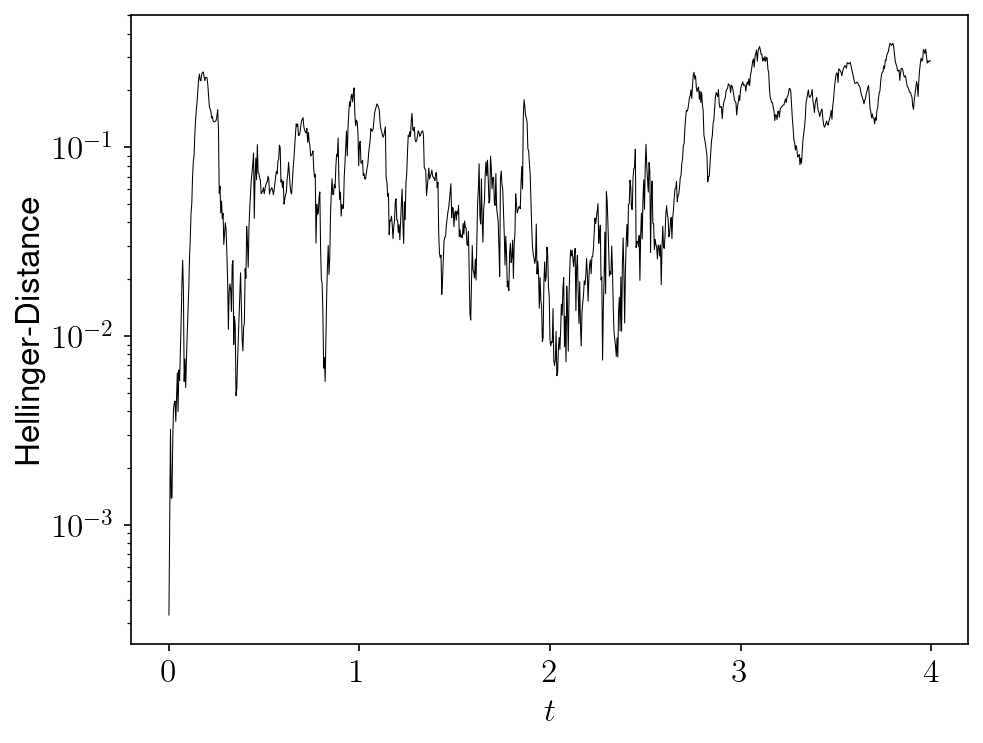

In [20]:
plt.figure(dpi=150)
plt.semilogy(tspan,hell_dist_hist,'-k',linewidth=0.5, label='Hellinger-Distance')
plt.xlabel('$t$')
plt.ylabel('Hellinger-Distance')
plt.tight_layout(pad=0.1)
plt.grid(False)
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.savefig('./heston/heston_hell_dist_hist.pdf')

/tmp/ipykernel_161220/3121069316.py:24: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color(white)
/tmp/ipykernel_161220/3121069316.py:25: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color(white)
/tmp/ipykernel_161220/3121069316.py:26: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color(white)


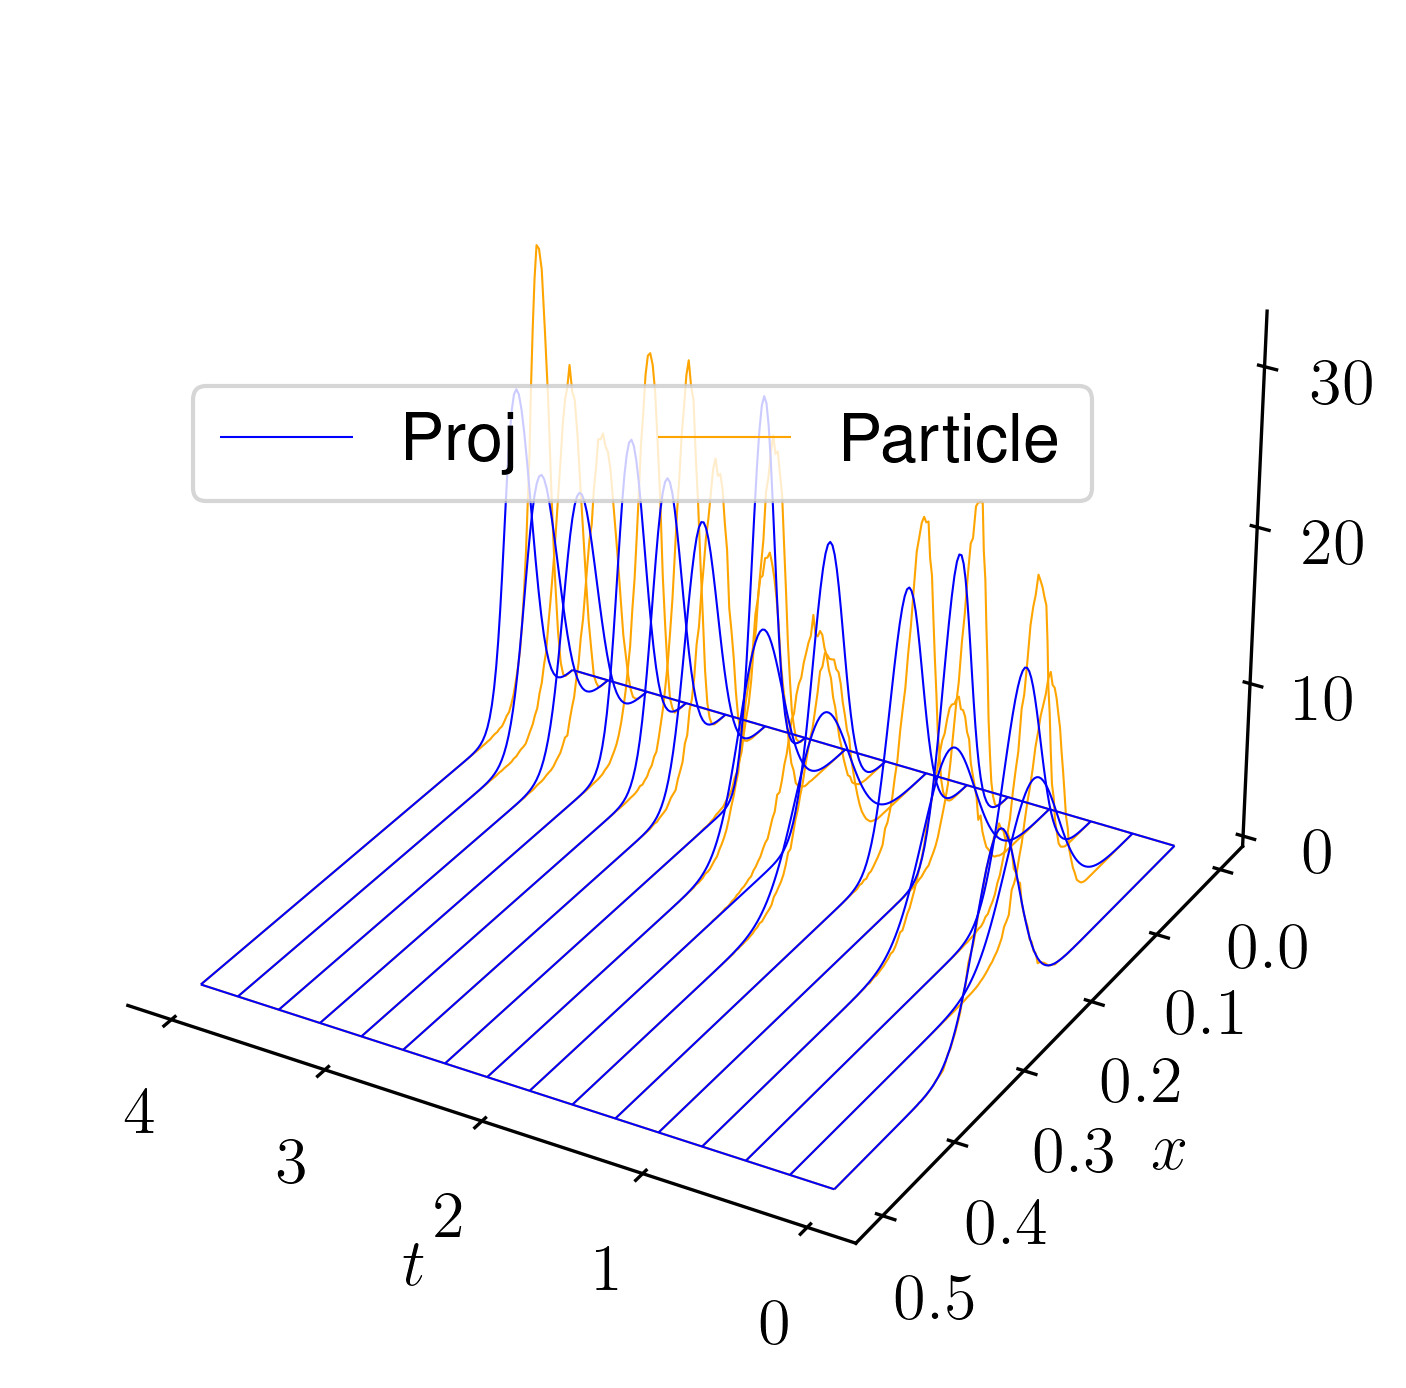

In [21]:
X_ = jnp.outer(jnp.ones(tspan.shape[0]),x_grid)
t_ = jnp.outer(tspan,jnp.ones(x_grid.shape[0]))
fig = plt.figure(dpi=300)
rcount = 15
ccount = 1
ax = fig.add_subplot(projection='3d')

ax.plot_wireframe(t_,X_, 
                  density_history_projection, 
                  rcount=rcount,ccount=ccount, 
                  linewidth=0.5, color='blue',
                  linestyle='-',
                  label='Proj')
ax.plot_wireframe(t_,X_, 
                  empirical_den_pf_history, 
                  rcount=rcount,ccount=ccount, 
                  linewidth=0.5, color='orange',
                  label='Particle')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$x$')
ax.set_zlabel(r'$p$')
ax.view_init(30, 120)
white = (1.0, 1.0, 1.0, 1.0)
ax.w_xaxis.set_pane_color(white)
ax.w_yaxis.set_pane_color(white)
ax.w_zaxis.set_pane_color(white)
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# plt.rc('legend', fontsize=8)    # legend fontsize
plt.legend(loc="upper left", ncol=2,bbox_to_anchor=(0.1,0.75))
plt.tight_layout()

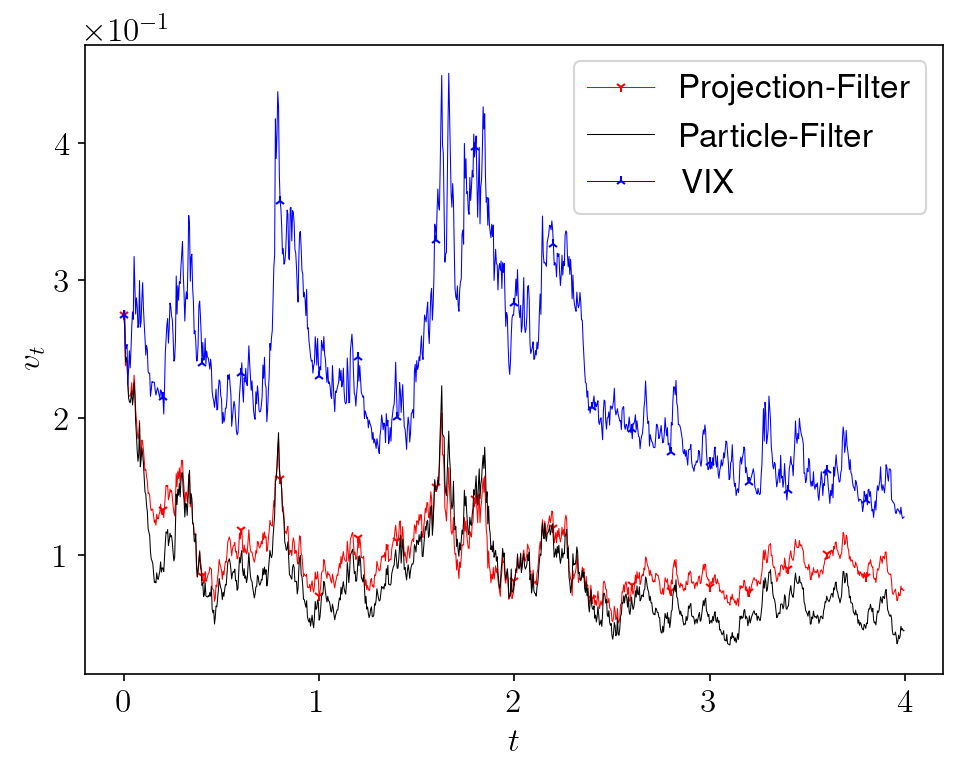

In [22]:
plt.figure(dpi=150)
plt.plot(tspan, moments_projection_filter[:, 0],'-r',linewidth=0.5,label='Projection-Filter',marker='1',markevery=markevery,ms=markersize)
plt.plot(tspan,moments_particle_filter[:,0],'-k',linewidth=0.5,label='Particle-Filter')
plt.plot(tspan, vix_history,'-b',linewidth=0.5,label='VIX',marker='2',markevery=markevery,ms=markersize)
plt.ylabel('$v_t$')
plt.xlabel('$t$')
plt.legend()
plt.tight_layout(pad=0.1)
plt.grid(False)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
# sns.despine()
plt.savefig('./heston/heston_volatility_comparison_with_vix.pdf')

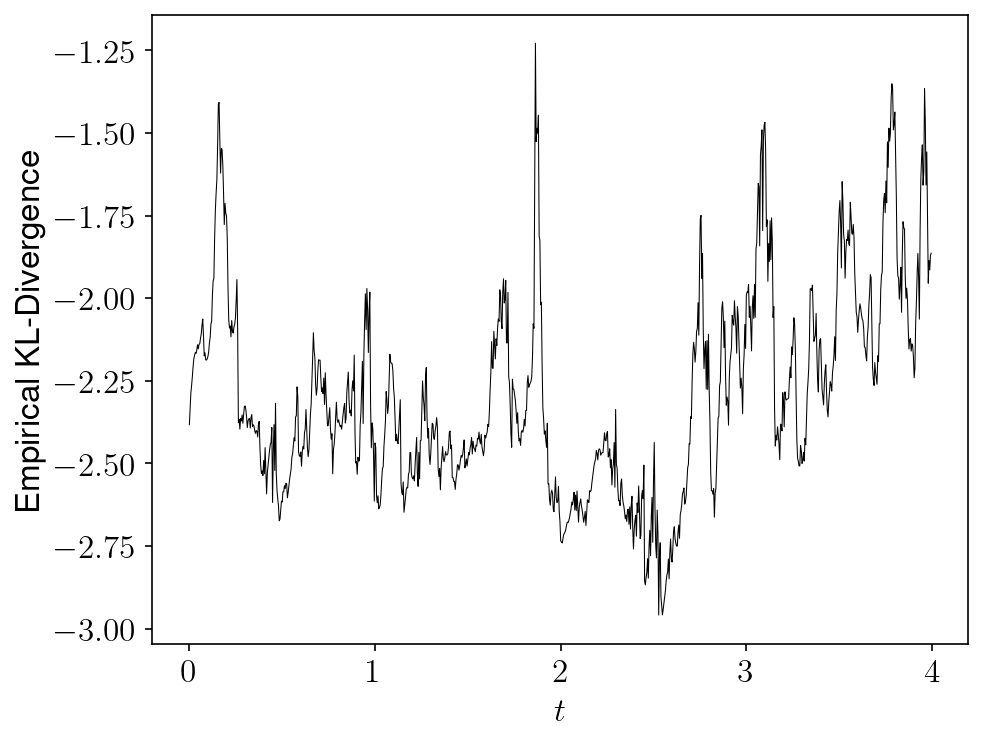

In [23]:
plt.figure(dpi=150)
plt.plot(tspan,rel_ent_history,'-k',linewidth=0.5, label='Empirical KL-divergence')
plt.xlabel('$t$')
plt.ylabel('Empirical KL-Divergence')
plt.tight_layout(pad=0.1)
plt.grid(False)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.savefig('./heston/heston_KL_divergence.pdf')